# Dynasty encode with M. Bukacek mapping

**Motivation:**  
This script converts the file `00_dynasty` into a more convenient format.  
- The file `00_dynasty` contains information about the dynasty for each person.  
- The dynasty values is preprocessed using the `adjust_dynasty` function from M. Bukáček (consulted with Egyptologist). This function converts string-formatted dynasty data into numbers (e.g., `late 2 – early 3` -> `late 2` -> `2.75`).


This script produces two DataFrames:
- `df_dynasty_numeric`: contains the dynasty encoded numerically.
- `df_dynasty_categorical`: contains the dynasty encoded into three categories using one-hot encoding.

### loads

In [1]:
import os
import numpy as np
import pandas as pd
import set_path
from supp.support_load import read_csv, read_excel
from supp.support_merge import merge, group_to_list
from supp.support_save import save_df
from supp.support_analyzer import make_excel_analysis
from supp.support_mbukacek_fce import adjust_dynasty

In [2]:
file_name = '00_dynasty_list'

In [3]:
# load dynasty file
dynasty_list = read_csv(file_name)
dynasty_list.set_index('ID_person', inplace=True)
dynasty_list = dynasty_list.astype(int)
# Convert wrong-encoded symbol 'â€' to '–'
dynasty_list.columns = dynasty_list.columns.map(lambda x: str(x).replace('â€“', '–'))
dynasty_list

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\unpacked\df_person_all\00_dynasty_list.csv


,10,18 or 19?,4,4–5,5,5 or 6,5–6,6,8,MK,...,late 6 or later,late 6 – early 7,late 8,mid 5,mid 5 or later,mid 5 – early 6,mid 6,mid 6 or later,middle 6,uncertain
ID_person,,,,,,,,,,,,,,,,,,,,,
322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# load dataframe with binary encoded titles
vizier__35_title_list = read_csv('vizier__35_title_list')

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\unpacked\df_person_all\merged\vizier__35_title_list.csv


### convert dynasty to numerical values

In [5]:
# Convert to long format and filter
df_dynasty = dynasty_list.stack()
df_dynasty = df_dynasty.reset_index()
df_dynasty.columns = ["ID_person", "dynasty", "value"]
# Keep only rows where value is 1
df_dynasty = df_dynasty[df_dynasty["value"] > 0]
df_dynasty = df_dynasty.sort_values(['ID_person', 'dynasty'])
df_dynasty

,ID_person,dynasty,value
8049,1,mid 5,1
21415,2,late 5,1
21418,2,late 5 – early 6,1
21425,2,mid 5,1
83555,4,mid 5,1
...,...,...,...
188349,4963,late 5,1
188387,4964,late 5,1
188422,4965,late 4,1
188492,4966,early 5,1


In [6]:
# apply map from MB
df_dynasty_num = adjust_dynasty(df_dynasty)
save_df(df_dynasty_num, 'df_dynasty_numeric')
df_dynasty_num

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_dynasty_numeric.csv


,ID_person,dyn_num
0,1,5.50
1,2,5.75
2,4,5.50
3,5,5.50
4,6,5.50
...,...,...
4835,4963,5.75
4836,4964,5.75
4837,4965,4.75
4838,4966,5.00


### convert dynasty to categorical values

<Axes: xlabel='dyn_num'>

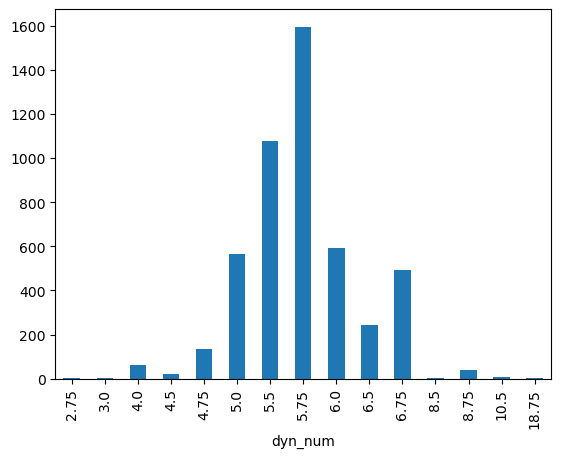

In [7]:
# plot dyn_num distribution
category_counts = df_dynasty_num['dyn_num'].value_counts().sort_index()
category_counts.plot(kind='bar')

**Note:** I will cluster the dynasty values into three clusters.  
- The thresholds are chosen with respect to:
    - To be consistend with publication:  
      *R. Mařík, V. Dulíková, Cyber-Egyptology: An overview of tools: Cybernetics, artificial intelligence, complex networks. In ‘Addressing the Dynamics of Change in Ancient Egypt: Complex Network Analysis’. Charles University Faculty of Arts, 2020, 29–70.*
        - In this publication, the authors studied periods of significant changes in the titulary of viziers (using a Hidden Markov Model).
        - See figure below.
    - Ensuring that each cluster has approximately the same size.


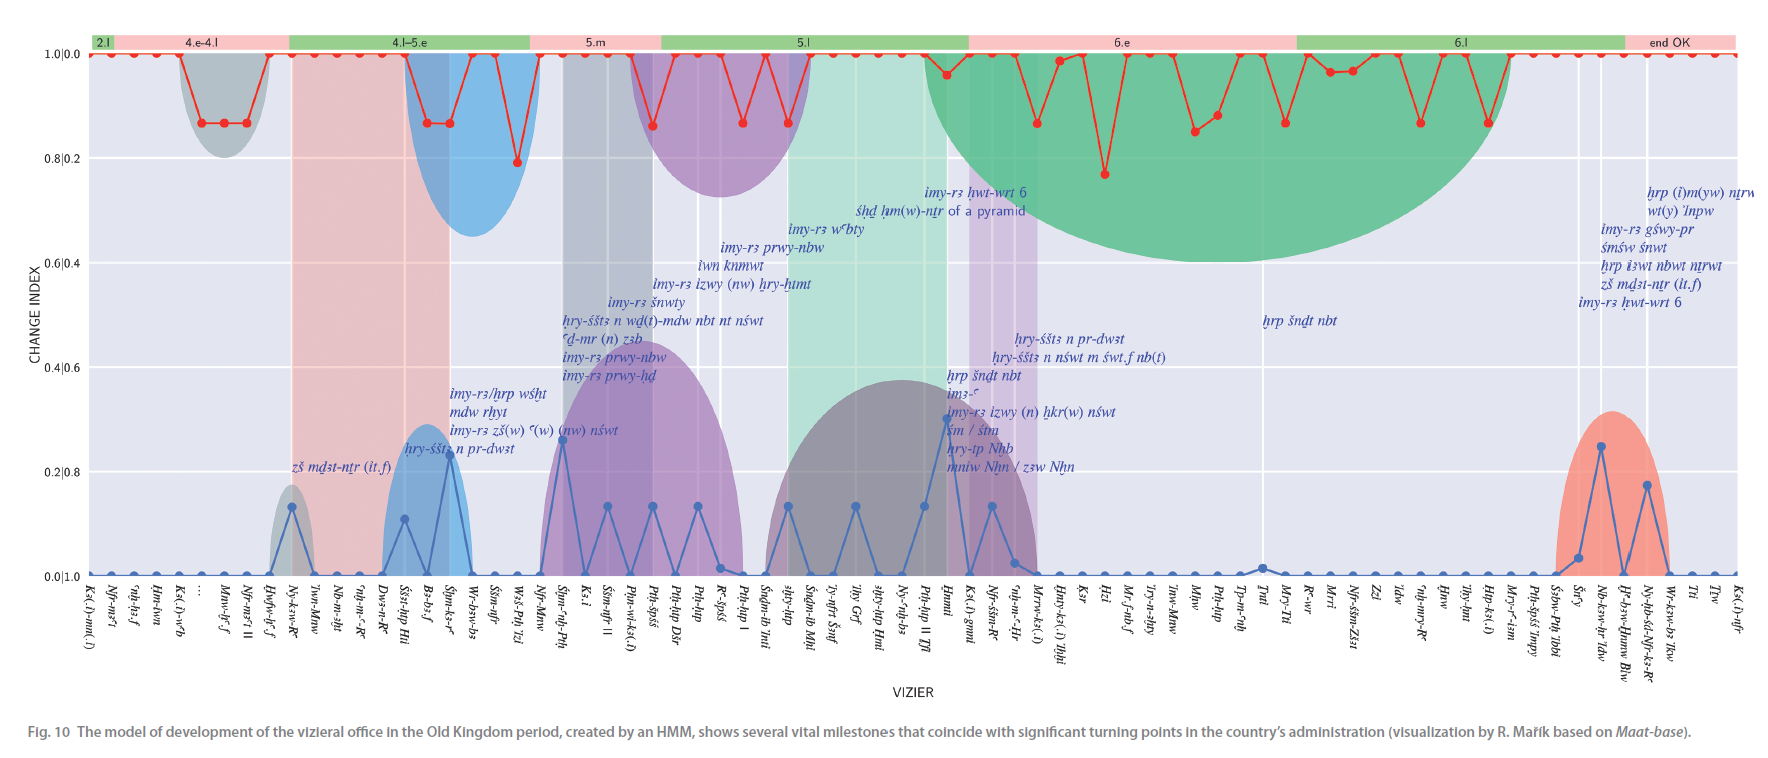

categorical
-1       3
 0    1865
 1    2185
 2     787
Name: count, dtype: int64

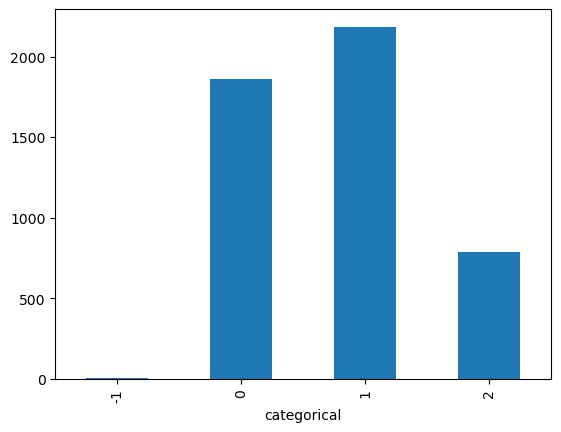

In [8]:
# clustering dyn_num into 3 clusters
threshold_1 = 5.5
threshold_2 = 6.5

df_dynasty_categorical = df_dynasty_num.copy()
# make mask
mask_1 = df_dynasty_num['dyn_num'] <= threshold_1
mask_2 = (df_dynasty_num['dyn_num'] > threshold_1) & (df_dynasty_num['dyn_num'] < threshold_2)
mask_3 = df_dynasty_num['dyn_num'] >= threshold_2
# define clusters
df_dynasty_categorical['categorical'] = -1   # default value
df_dynasty_categorical.loc[mask_1, 'categorical'] = 0
df_dynasty_categorical.loc[mask_2, 'categorical'] = 1
df_dynasty_categorical.loc[mask_3, 'categorical'] = 2

category_cat_counts = df_dynasty_categorical['categorical'].value_counts().sort_index()
category_cat_counts.plot(kind='bar')
category_cat_counts

#### analyze persons with nan dynasty

In [9]:
# person with nan category
df_help = df_dynasty_categorical.loc[df_dynasty_categorical['categorical']==-1, :]
id_nan = df_help.index.to_list()
print(f'{id_nan=}')
df_help

id_nan=[685, 3030, 4197]


,ID_person,dyn_num,categorical
685,696,NaN,-1
3030,3048,NaN,-1
4197,4235,NaN,-1


In [10]:
# overview of persons with nan dynasty
vizier__35_title_list.loc[vizier__35_title_list['ID_person'].isin(id_nan), :]

,ID_person,vizier,(cmcw ?) wxrt aAt,(wnn) imAx.c nfr xr Ra nb Axt(y),... 1p,... BA-Nfr-ir-kA-ra,... Hct n xnt[yw-S],... Hm(w)-nTr ... m Cxt-Ra,... Hm-kA,... Hm-nTr 1wt-1r,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
406,685,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2952,3030,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4154,4197,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# overview of persons with nan dynasty
print('Number of titles for persons with nan dynasty:')
vizier__35_title_list.loc[vizier__35_title_list['ID_person'].isin(id_nan), :].set_index('ID_person').sum(axis=1)

Number of titles for persons with nan dynasty:


ID_person
685     0.0
3030    0.0
4197    1.0
dtype: float64

**NOTE:**
- None of the persons with a `NaN` dynasty value is a vizier.  
- They have at most one title.  
- I will remove these persons from the dataset, because I want to use dynasty as a feature in the models.  
- These individuals have few titles, and thus a low probability of being viziers — so no significant information is lost by removing them.

#### analyze persons with very late dynasty (dynasty>9)

In [12]:
# persons with very late dynasty
df_help = df_dynasty_categorical.loc[df_dynasty_categorical['dyn_num']>9, :]
df_help = df_help.sort_values(['dyn_num', 'ID_person'])
id_new_quy = df_help.index.to_list()
print(f'{id_new_quy=}')
df_help

id_new_quy=[3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 799]


,ID_person,dyn_num,categorical
3504,3531,10.50,2
3505,3532,10.50,2
3506,3533,10.50,2
3507,3534,10.50,2
3508,3535,10.50,2
3509,3536,10.50,2
3510,3537,10.50,2
3511,3538,10.50,2
799,810,18.75,2


In [13]:
# overview of persons with very late dynasty
vizier__35_title_list.loc[vizier__35_title_list['ID_person'].isin(id_new_quy), :]

,ID_person,vizier,(cmcw ?) wxrt aAt,(wnn) imAx.c nfr xr Ra nb Axt(y),... 1p,... BA-Nfr-ir-kA-ra,... Hct n xnt[yw-S],... Hm(w)-nTr ... m Cxt-Ra,... Hm-kA,... Hm-nTr 1wt-1r,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
530,799,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3434,3504,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3435,3505,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3436,3506,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3437,3507,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3438,3508,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3439,3509,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3440,3510,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3441,3511,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# overview of persons with very late dynasty
print('Number of titles for persons with very late dynasty:')
vizier__35_title_list.loc[vizier__35_title_list['ID_person'].isin(id_new_quy), :].set_index('ID_person').sum(axis=1)

Number of titles for persons with very late dynasty:


ID_person
799     1.0
3504    8.0
3505    1.0
3506    1.0
3507    0.0
3508    1.0
3509    0.0
3510    0.0
3511    3.0
dtype: float64

**NOTE:**
- None of the persons with a very late dynasty (dynasty > 9) is a vizier.  
- They have at most 8 titles.  
- I will remove them from the dataset. The aim is to analyze individuals from dynasties 3 to 6, not those from dynasty > 9.


#### postprocessing

In [15]:
# remove nan categories
print(f'{df_dynasty_categorical.shape}\tshape of df_dynasty_categorical before removing')
df_dynasty_categorical = df_dynasty_categorical.loc[~df_dynasty_categorical['ID_person'].isin(id_nan), :]
print(f'{df_dynasty_categorical.shape}\tshape of df_dynasty_categorical after removing')

(4840, 3)	shape of df_dynasty_categorical before removing
(4837, 3)	shape of df_dynasty_categorical after removing


In [16]:
# remove persons with very late dynasty
print(f'{df_dynasty_categorical.shape}\tshape of df_dynasty_categorical before removing')
df_dynasty_categorical = df_dynasty_categorical.loc[~df_dynasty_categorical['ID_person'].isin(id_new_quy), :]
print(f'{df_dynasty_categorical.shape}\tshape of df_dynasty_categorical after removing')

(4837, 3)	shape of df_dynasty_categorical before removing
(4828, 3)	shape of df_dynasty_categorical after removing


In [17]:
# make one hot encoding of category
df_dynasty_categorical['dynasty_0'] = (df_dynasty_categorical['categorical']==0)*1
df_dynasty_categorical['dynasty_1'] = (df_dynasty_categorical['categorical']==1)*1
df_dynasty_categorical['dynasty_2'] = (df_dynasty_categorical['categorical']==2)*1
df_dynasty_categorical.head()

,ID_person,dyn_num,categorical,dynasty_0,dynasty_1,dynasty_2
0,1,5.50,0,1,0,0
1,2,5.75,1,0,1,0
2,4,5.50,0,1,0,0
3,5,5.50,0,1,0,0
4,6,5.50,0,1,0,0


#### save

In [18]:
# define columns to keep in the final dataframe
columns_to_keep = ['ID_person',
                   'dynasty_0',
                   'dynasty_1',
                   'dynasty_2'
                  ]
df_dynasty_categorical_final = df_dynasty_categorical.loc[:, columns_to_keep]
save_df(df_dynasty_categorical_final, 'df_dynasty_categorical')
df_dynasty_categorical_final.head()

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_dynasty_categorical.csv


,ID_person,dynasty_0,dynasty_1,dynasty_2
0,1,1,0,0
1,2,0,1,0
2,4,1,0,0
3,5,1,0,0
4,6,1,0,0
